In [2]:
import xarray as xr
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from bbl_utils import *

# Progress bar for dask stuff
#from dask.diagnostics import ProgressBar
#ProgressBar().register()

import warnings
warnings.filterwarnings('ignore', '.*.')

nancol = (0.8,0.8,0.8)

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=nancol)

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=nancol)

In [3]:
n = 5
diter = 28800
iter0 = 3182400
iters = np.arange(iter0, iter0+n*diter, diter)
iters

array([3182400, 3211200, 3240000, 3268800, 3297600])

### Physical parameters

In [4]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

### Test grid pre-processing

In [5]:
data_dir_2D = f"../../MITgcm/experiments/rotated_BBTRE_rest-tracer/run/"
ds = open_mdsdataset(data_dir_2D,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag", "tracer01Diag", "tracer02Diag"], delta_t=60.)

In [7]:
#ds = open_mdsdataset(data_dir_2D,iters=iters,ignore_unknown_vars=True,prefix=["levelDiag"], delta_t=60., levels=[50,70,90])

In [8]:
def parallel_combine(ds_list, concat_dims):
    ds_new_list = []
    for concat_dim in concat_dims:
        tmp_list = []
        for ds in ds_list:
            tmp = ds.copy()
            for var in (list(ds.data_vars) + list(ds.coords)):
                if (concat_dim not in ds[var].dims) & any([(dim in concat_dims) for dim in ds[var].dims]):
                    tmp = tmp.drop_vars(var)
            tmp_list.append(tmp)
        ds_new_list.append(xr.combine_by_coords(tmp_list))
    return xr.merge(ds_new_list)

In [9]:
def periodic_extend(ds, concat_dims, dim_length, extend_multiples):
    ds_list = []
    for extend in range(extend_multiples[0], extend_multiples[1]+1):
        tmp = ds.copy()
        tmp_attrs = [tmp[dim].attrs for dim in concat_dims]
        for dim in concat_dims:
            tmp[dim] = tmp[dim] + extend*dim_length
        ds_list.append(tmp)
    ds = parallel_combine(ds_list, concat_dims = concat_dims)
    for i, dim in enumerate(concat_dims):
        ds[dim].attrs = tmp_attrs[i]
    return ds

In [ ]:
dx = 500.
Lx = ds['XC'].size*dx
extend_multiples = [-1, 0]
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds = ds.sel(XC=slice(-0.5e5, 1e5))

In [11]:
H = ds['Depth'].max().values.copy().astype('>f8')
ds['Z'] += H
ds['Zl'] += H
ds['Zu'] += H
ds['Zp1'] += H

grid = Grid(ds, periodic=['X', 'Y'])

ds = ds.assign_coords({
    'Zr': (['XC', 'Z'], (ds['XC']*np.sin(θ) + ds['Z']*np.cos(θ)).values),
    'Xr': (['XC', 'Z'], (ds['XC']*np.cos(θ) - ds['Z']*np.sin(θ)).values),
    'Zr_V': (['XC', 'Z'], (ds['XC']*np.sin(θ) + ds['Z']*np.cos(θ)).values),
    'Xr_V': (['XC', 'Z'], (ds['XC']*np.cos(θ) - ds['Z']*np.sin(θ)).values),
    'Zr_U': (['XG', 'Z'], (ds['XG']*np.sin(θ) + ds['Z']*np.cos(θ)).values),
    'Xr_U': (['XG', 'Z'], (ds['XG']*np.cos(θ) - ds['Z']*np.sin(θ)).values),
    'Zr_W': (['XC', 'Zl'], (ds['XC']*np.sin(θ) + ds['Zl']*np.cos(θ)).values),
    'Xr_W': (['XC', 'Zl'], (ds['XC']*np.cos(θ) - ds['Zl']*np.sin(θ)).values)
})

ds['Depthr'] = ds['Depth'] - ds['XC']*np.tan(θ)

ds['THETA_BG_C'] = Γ*ds['Zr']
ds['THETA_BG_U'] = Γ*ds['Zr_U']
ds['THETA_BG_V'] = Γ*ds['Zr_V']
ds['THETA_BG_W'] = Γ*ds['Zr_W']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

volume = (ds.drF * ds.rA * ds.hFacC)
day2seconds = (24*60*60)**-1

In [12]:
TRAC01_xy = (ds['TRAC01']*ds['drF']).sel(XC=slice(-1e5,3e5)).sum(dim='Z').isel(time=-1).compute()
TRAC01_xy /= TRAC01_xy.max()
TRAC01_xz = (ds['TRAC01']*ds['rA']).sel(XC=slice(-1e5,3e5)).sum(dim='YC').isel(time=-1).compute()
TRAC01_xz /= TRAC01_xz.max()

TRAC02_xy = (ds['TRAC02']*ds['drF']).sel(XC=slice(-1e5,3e5)).sum(dim='Z').isel(time=-1).compute()
TRAC02_xy /= TRAC02_xy.max()
TRAC02_xz = (ds['TRAC02']*ds['rA']).sel(XC=slice(-1e5,3e5)).sum(dim='YC').isel(time=-1).compute()
TRAC02_xz /= TRAC02_xz.max()

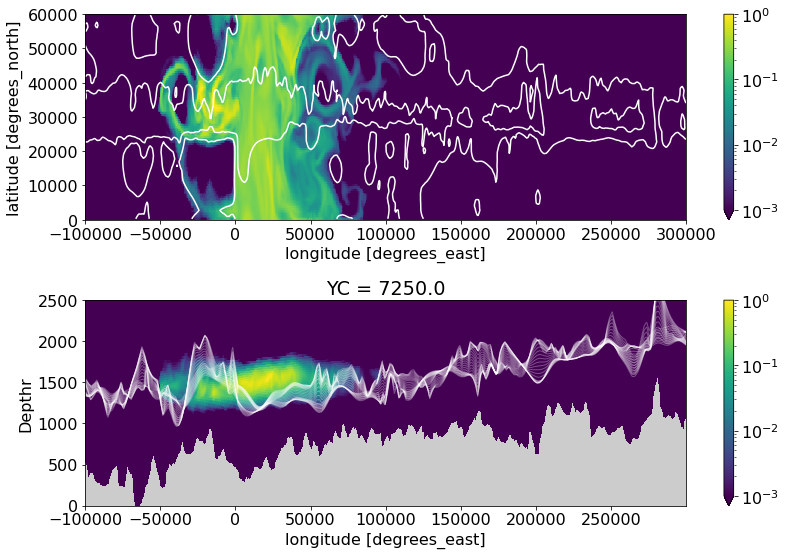

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
TRAC01_xy.plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e0))
(H-ds['Depthr']).sel(XC=slice(-1e5,3e5)).plot.contour(colors="w", levels=[1000, 1500])

plt.subplot(2,1,2, facecolor=nancol)
TRAC01_xz.plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e0))
for i in range(-15,15):
    (H-ds['Depthr']).isel(YC=i).sel(XC=slice(-1e5,3e5)).plot(color="w", alpha=0.3, lw=1.)
plt.plot([-1e5,3e5], [1000,1000], "w--", alpha=0.5)
plt.plot([-1e5,3e5], [1500,1500], "w--", alpha=0.5)
plt.ylim(0, 2500)

plt.tight_layout()

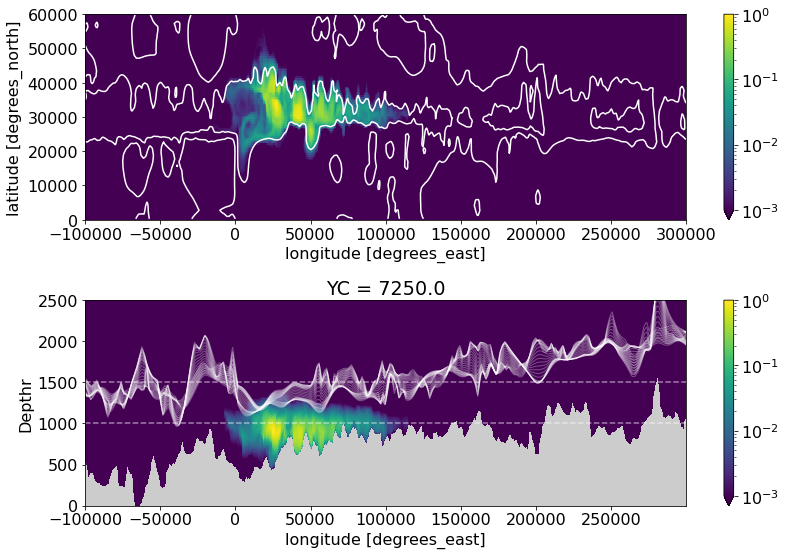

In [30]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
TRAC02_xy.plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e0))
(H-ds['Depthr']).sel(XC=slice(-1e5,3e5)).plot.contour(colors="w", levels=[1000, 1500])

plt.subplot(2,1,2, facecolor=nancol)
TRAC02_xz.plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e0))
for i in range(-15,15):
    (H-ds['Depthr']).isel(YC=i).sel(XC=slice(-1e5,3e5)).plot(color="w", alpha=0.3, lw=1.)
plt.plot([-1e5,3e5], [1000,1000], "w--", alpha=0.5)
plt.plot([-1e5,3e5], [1500,1500], "w--", alpha=0.5)
plt.ylim(0, 2500)

plt.tight_layout()

In [20]:
Uflux = (ds['UVEL']*ds['dyG']).sel(XG=slice(-1e5,3e5)).sum(dim='YC').isel(time=-1).compute()
Uflux = Uflux.where(Uflux!=0.)

In [25]:
Wflux = (ds['WVEL']*ds['rA']).sel(XC=slice(-1e5,3e5)).sum(dim='YC').isel(time=-1).compute()
Wflux = Wflux.where(Wflux!=0.)

(0.0, 2500.0)

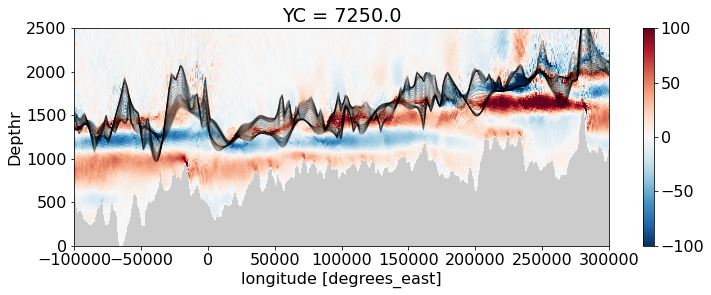

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,1,1, facecolor=nancol)
q = Uflux.plot(x='Xr_U', y='Zr_U')
q.set_clim([-100,100])
for i in range(-15,15):
    (H-ds['Depthr']).isel(YC=i).sel(XC=slice(-1e5,3e5)).plot(color="k", alpha=0.3, lw=1.)
plt.ylim(0, 2500)

(0.0, 2500.0)

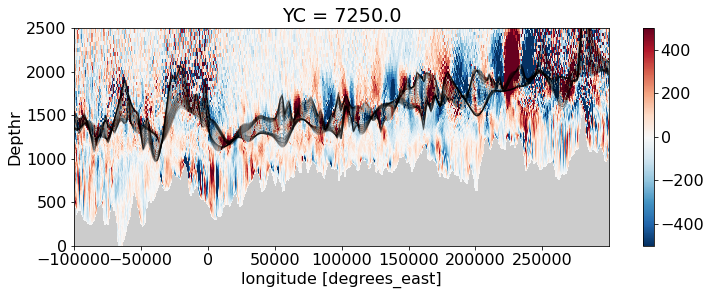

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,1,1, facecolor=nancol)
q = Wflux.plot(x='Xr_W', y='Zr_W')
q.set_clim([-500,500])
for i in range(-15,15):
    (H-ds['Depthr']).isel(YC=i).sel(XC=slice(-1e5,3e5)).plot(color="k", alpha=0.3, lw=1.)
plt.ylim(0, 2500)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,1,1, facecolor=nancol)
q = Uflux.plot(x='Xr_U', y='Zr_U')
q.set_clim([100,100])
for i in range(-15,15):
    (H-ds['Depthr']).isel(YC=i).sel(XC=slice(-1e5,3e5)).plot(color="k", alpha=0.3, lw=1.)
plt.ylim(0, 2500)

(100.0, 3000.0)

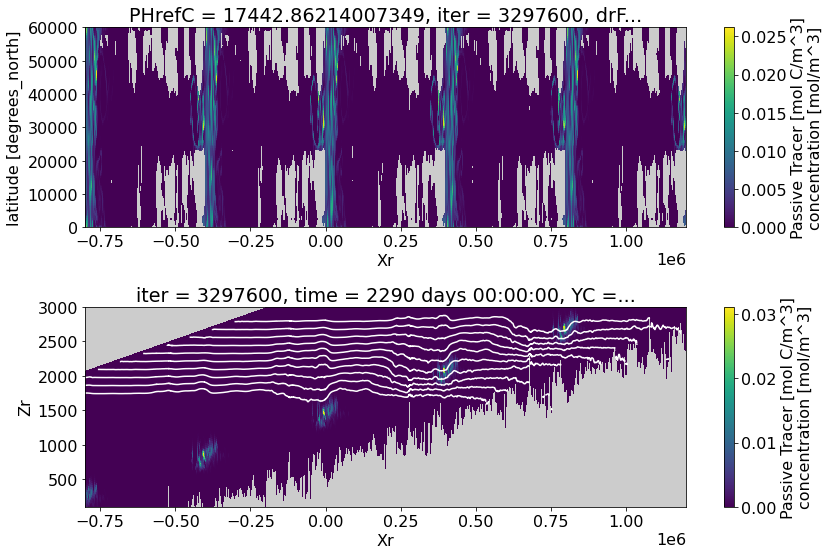

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=1500, method='nearest').plot(x='Xr', y='YC')

plt.subplot(2,1,2, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr')
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(1.5, 2.5, 0.1), colors='w', lw=0.75)
plt.tight_layout()
plt.ylim([100, 3000])

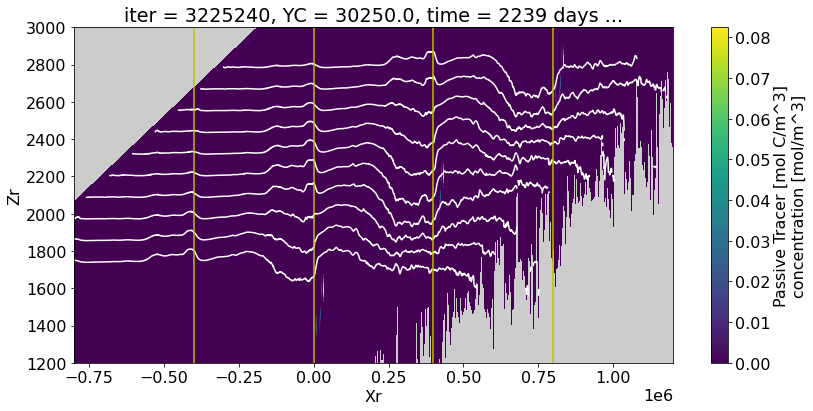

In [69]:
plt.figure(figsize=(12,6))
plt.subplot(1,1,1, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr')
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(1.5, 2.5, 0.1), colors='w', lw=0.75)
plt.tight_layout()
plt.ylim([1200, 3000])

for i in range(*extend_multiples):
    plt.axvline(x=(i+1)*(800*500), alpha=1, linestyle="-", color="y")

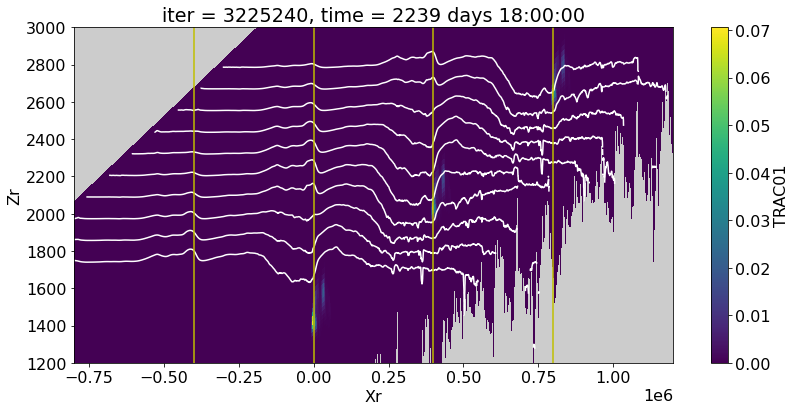

In [70]:
plt.figure(figsize=(12,6))
plt.subplot(1,1,1, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).mean(dim='YC').plot(x='Xr', y='Zr')
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).mean(dim='YC').plot.contour(x='Xr', y='Zr', levels=np.arange(1.5, 2.5, 0.1), colors='w', lw=0.75)
plt.tight_layout()
plt.ylim([1200, 3000])

for i in range(*extend_multiples):
    plt.axvline(x=(i+1)*(800*500), alpha=1, linestyle="-", color="y")

## Temperature and tracer budgets

In [12]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where
    `suffix` is `_TH`, `Tr01`, or 'Tr02'. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(ds['ADVx' + suffix], 'X') +
                          grid.diff(ds['ADVy' + suffix], 'Y')).rename('conv_horiz_adv_flux' + suffix)
    conv_horiz_diff_flux = -(grid.diff(ds['DFxE' + suffix], 'X') +
                          grid.diff(ds['DFyE' + suffix], 'Y')).rename('conv_horiz_diff_flux' + suffix)

    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = grid.diff(ds['ADVr' + suffix], 'Z', boundary='fill').rename('conv_vert_adv_flux' + suffix)
    conv_vert_diff_flux = grid.diff(ds['DFrI' + suffix], 'Z', boundary='fill').rename('conv_vert_diff_flux' + suffix)

    all_fluxes = [
        conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux
    ]

    if suffix=="_TH":
        # anomalous fluxes
        conv_vert_diff_flux_anom = -(grid.diff(ds['KVDIFF'].where(ds['WVEL'] != 0.), 'Z', boundary='fill')/(ds['drF']*ds['hFacC'])*np.cos(θ)*Γ*volume).rename('conv_vert_diff_flux_anom' + suffix)
        conv_adv_flux_anom = -(
            grid.interp(ds['UVEL'], 'X')*Γ*np.sin(θ)*volume +
            grid.interp(ds['WVEL'], 'Z', boundary='fill')*Γ*np.cos(θ)*volume
        ).rename('conv_adv_flux_anom' + suffix)
        all_fluxes += [conv_vert_diff_flux_anom, conv_adv_flux_anom]

    conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux' + suffix)

    return xr.merge(all_fluxes + [conv_all_fluxes]).chunk({'Z': -1, 'YC': -1, 'XC': -1})

In [13]:
TH = tracer_flux_budget('_TH')
TH['total_tendency_TH'] = TH['conv_total_flux_TH'].fillna(0.)
TH['total_tendency_TH_truth'] = ds.TOTTTEND * volume * day2seconds
TH['diff_tendency_TH'] = TH['conv_horiz_diff_flux_TH'] + TH['conv_vert_diff_flux_TH'] + TH['conv_vert_diff_flux_anom_TH']
TH['adv_tendency_TH'] = TH['conv_horiz_adv_flux_TH'] + TH['conv_vert_adv_flux_TH'] + TH['conv_adv_flux_anom_TH']

Tr01 = tracer_flux_budget('Tr01')
Tr01['total_tendency_Tr01'] = Tr01['conv_total_fluxTr01'].fillna(0.)
Tr01['total_tendency_Tr01_truth'] = ds.Tp_gTr01 * volume
Tr01['diff_tendency_Tr01'] = Tr01['conv_horiz_diff_fluxTr01'] + Tr01['conv_vert_diff_fluxTr01']
Tr01['adv_tendency_Tr01'] = Tr01['conv_horiz_adv_fluxTr01'] + Tr01['conv_vert_adv_fluxTr01']

Tr02 = tracer_flux_budget('Tr02')
Tr02['total_tendency_Tr02'] = Tr02['conv_total_fluxTr02'].fillna(0.)
Tr02['total_tendency_Tr02_truth'] = ds.Tp_gTr02 * volume
Tr02['diff_tendency_Tr02'] = Tr02['conv_horiz_diff_fluxTr02'] + Tr02['conv_vert_diff_fluxTr02']
Tr02['adv_tendency_Tr02'] = Tr02['conv_horiz_adv_fluxTr02'] + Tr02['conv_vert_adv_fluxTr02']

### Watermass transformations

\begin{equation}
T(\Theta) = \partial_{\Theta} \int_{V_{b'<b}} \nabla \cdot \left( \kappa \nabla \Theta \right) \;\text{d}V
\end{equation}

In [14]:
dθ = 0.1
θ_levs = np.arange(1.5, 2.5+dθ, dθ)
formation = np.zeros((θ_levs.size, 3))
for k, θ_lev in enumerate(θ_levs):
    print(k, end=", ")
    formation[k, 0] = TH['diff_tendency_TH'].where((ds['θ'] < θ_lev)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values
    formation[k, 1] = TH['diff_tendency_TH'].where((ds['θ'] < θ_lev) | (TH['diff_tendency_TH'] >= 0.)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values
    formation[k, 2] = TH['diff_tendency_TH'].where((ds['θ'] < θ_lev) | (TH['diff_tendency_TH'] <= 0.)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values
    
transformation = -np.diff(formation, axis=0)/dθ

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

In [35]:
formation_dbdt = np.zeros(θ_levs.size)
for k, θ_lev in enumerate(θ_levs):
    print(k, end=", ")
    formation_dbdt[k] = TH['total_tendency_TH_truth'].where((ds['θ'] < θ_lev)).isel(time=-1).sum(dim=['XC', 'YC', 'Z']).compute().values

transformation_dbdt = -np.diff(formation_dbdt)/dθ

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

(1.55, 2.35)

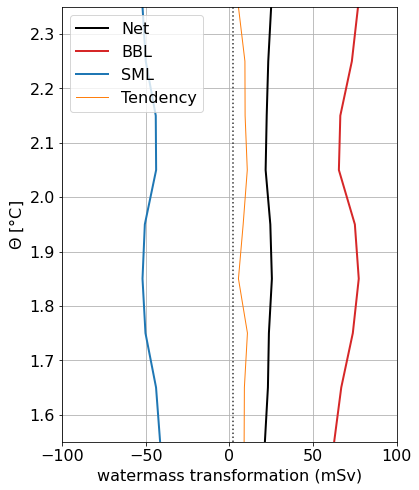

In [56]:
θ_levs_f = 0.5*(θ_levs[1:] + θ_levs[0:-1])
labels = ['Net', 'BBL', 'SML']
colors = ['k', 'C3', 'C0']

plt.figure(figsize=(6,8))
for i in range(3):
    plt.plot(transformation[:,i]*1.e-3, θ_levs_f, label=labels[i], color=colors[i], lw=2.)

plt.plot(transformation_dbdt[:]*1.e-3, θ_levs_f, color="C1", lw=1., label="Tendency")
    
Tinf = 5.2e-5 * np.tan(θ)**(-1) * 120 * 500
plt.axvline(x=Tinf*1.e-3, alpha=0.8, linestyle=":", color="k")
plt.grid(True)
plt.legend()
plt.xlabel("watermass transformation (mSv)")
plt.ylabel(r"$\Theta$ [$\degree$C]")
plt.xlim([-100, 100])
plt.ylim([1.55, 2.35])

(0.0, 400000.0)

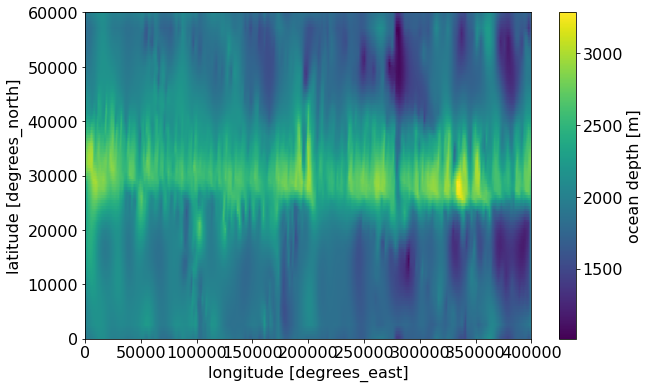

In [72]:
ds['Depth'].plot()
plt.xlim([0*1.e4,4e5])

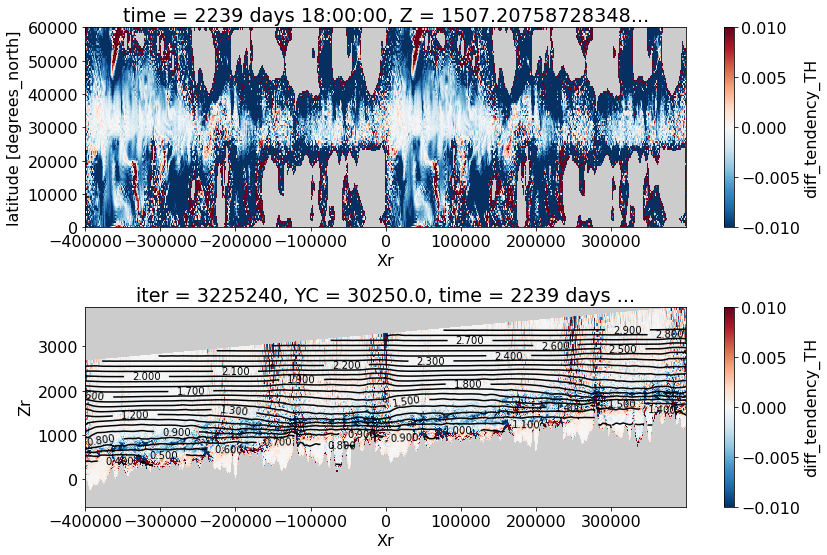

In [45]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
q = TH['diff_tendency_TH'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=1500, method='nearest').plot(x='Xr', y='YC')
q.set_clim([-1.e-2,1.e-2])

ax = plt.subplot(2,1,2, facecolor=nancol)
q = TH['diff_tendency_TH'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr')
q.set_clim([-1.e-2,1.e-2])
CS = ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(0., 3., 0.1), colors='k', lw=0.75)
ax.clabel(CS, inline=1, fontsize=10)
plt.tight_layout()
#plt.ylim([100, 1700])

(1200.0, 3000.0)

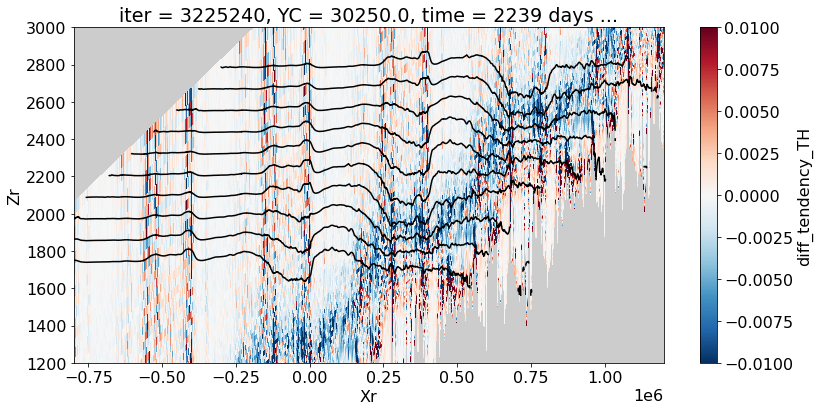

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(1,1,1, facecolor=nancol)
q = TH['diff_tendency_TH'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr')
q.set_clim([-1.e-2,1.e-2])
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(1.5, 2.5, 0.1), colors='k', lw=0.75)
plt.tight_layout()
plt.ylim([1200, 3000])

### Verification: closing the temperature and tracer budgets

In [ ]:
TH_chk = TH[['total_tendency_TH', 'total_tendency_TH_truth']].sum(dim=['Z', 'YC']).mean(dim='time').load()

Tr01_chk = Tr01[['total_tendency_Tr01', 'total_tendency_Tr01_truth']].sum(dim=['Z', 'YC']).mean(dim='time').load()

Tr02_chk = Tr02[['total_tendency_Tr02', 'total_tendency_Tr02_truth']].sum(dim=['Z', 'YC']).mean(dim='time').load()

[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.1s
[########################################] | 100

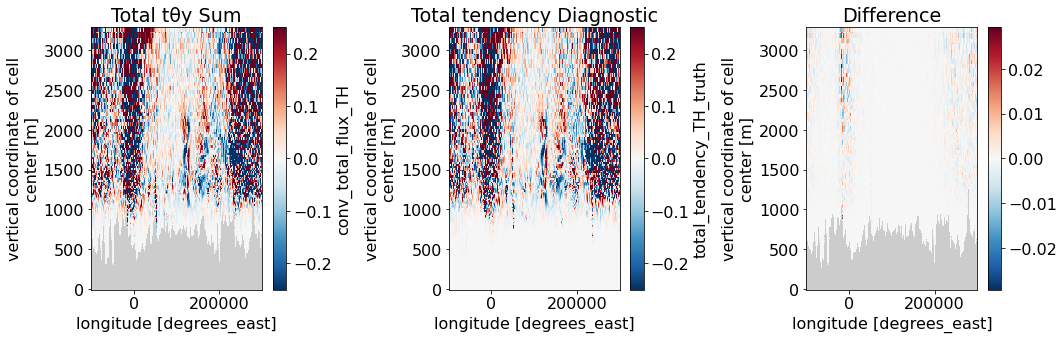

In [320]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
q = TH['conv_total_flux_TH'].isel(YC=60, time=-1).plot()
q.set_clim([-0.25, 0.25])
plt.title("Total tθy Sum")

plt.subplot(1,3,2)
q = TH['total_tendency_TH_truth'].isel(YC=60, time=-1).plot()
q.set_clim([-0.25,0.25])
plt.title("Total tendency Diagnostic")

plt.subplot(1,3,3)
(TH['total_tendency_TH_truth'].isel(YC=60, time=-1) - TH['conv_total_flux_TH'].isel(YC=60, time=-1)).plot()
plt.title("Difference")

plt.tight_layout()

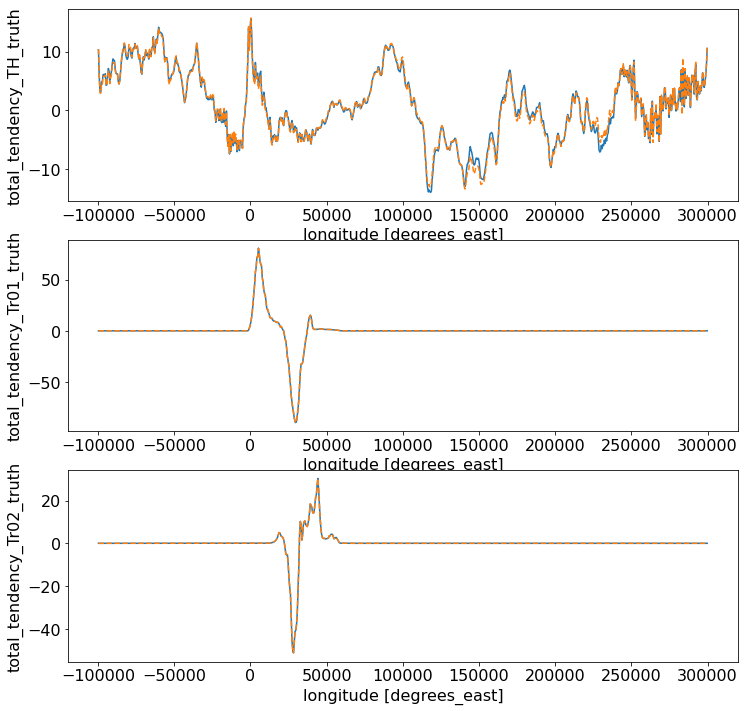

In [321]:
plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
TH_chk['total_tendency_TH'].plot()
TH_chk['total_tendency_TH_truth'].plot(linestyle="--")

plt.subplot(3,1,2)
Tr01_chk['total_tendency_Tr01'].plot()
Tr01_chk['total_tendency_Tr01_truth'].plot(linestyle="--")

plt.subplot(3,1,3)
Tr02_chk['total_tendency_Tr02'].plot()
Tr02_chk['total_tendency_Tr02_truth'].plot(linestyle="--")

### Tracer-weighted density (first moment)

The rate of change of the first temperature moment $\overline{\Theta} = \dfrac{\int \Theta c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we use the follow , where each term can be diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed. In practice, hyperdiffusion has a small but non-zero effect on the buoyancy budget and since it is omitted here, it introduces small errors in the budget.

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [322]:
ds['θ_dcdt'] = ds['θ'] * ds['Tp_gTr01'] * volume
ds['c_dθdt'] = ds['TRAC01'] * (ds['TOTTTEND']* day2seconds) * volume

ds['d(cθ)dt'] = ds['θ_dcdt'] + ds['c_dθdt']

In [ ]:
ds['M_TRAC01'] = (ds['TRAC01']*volume).sum(dim=['Z', 'YC', 'XC']).compute()
ds['θbar'] = (ds['d(cθ)dt'].sum(dim=['Z', 'YC', 'XC']) / ds['M_TRAC01']).compute()

In [ ]:
ds['c_div_uθ'] = ds['TRAC01']*TH['adv_tendency_TH']
ds['θ_div_uc'] = ds['θ']*Tr01['adv_tendency_Tr01']

In [ ]:
ds['c_div_Fθ'] = ds['TRAC01']*TH['diff_tendency_TH']
ds['θ_div_Fc'] = ds['θ']*Tr01['diff_tendency_Tr01']

In [ ]:
ds['d(cθ)dt_DIFF'] = ds['c_div_Fθ'] + ds['θ_div_Fc']
ds['θbar_DIFF'] = (ds['d(cθ)dt_DIFF'].sum(dim=['Z', 'YC', 'XC']) / ds['M_TRAC01']).compute()

ds['d(cθ)dt_ADV'] = ds['c_div_uθ'] + ds['θ_div_uc']
ds['θbar_ADV'] = (ds['d(cθ)dt_ADV'].sum(dim=['Z', 'YC', 'XC']) / ds['M_TRAC01']).compute()

ds['θbar_RHS'] = ds['θbar_DIFF'] + ds['θbar_ADV']

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100

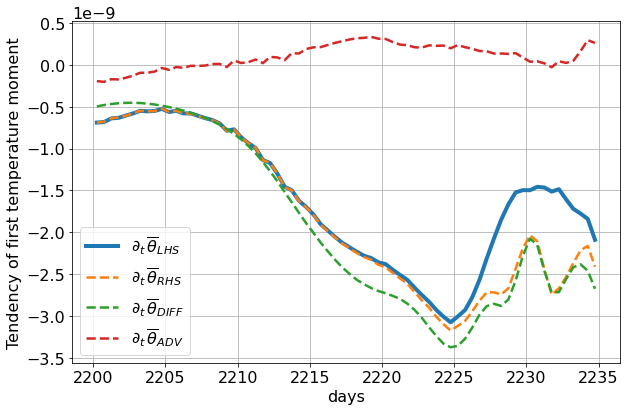

In [343]:
ds['days'] = ds['time'].astype("float64")*(1.e-9)/86400.
ds = ds.assign_coords({'days': ds['days']})

plt.figure(figsize=(9,6))
ds['θbar'].plot(x='days', lw=4, label=r"$\partial_{t}\, \overline{\theta}_{LHS}$")
ds['θbar_RHS'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{RHS}$")
ds['θbar_DIFF'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{DIFF}$")
ds['θbar_ADV'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{ADV}$")
plt.legend()
plt.ylabel("Tendency of first temperature moment")
plt.grid(True)

plt.tight_layout()

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100

(300.0, 2000.0)

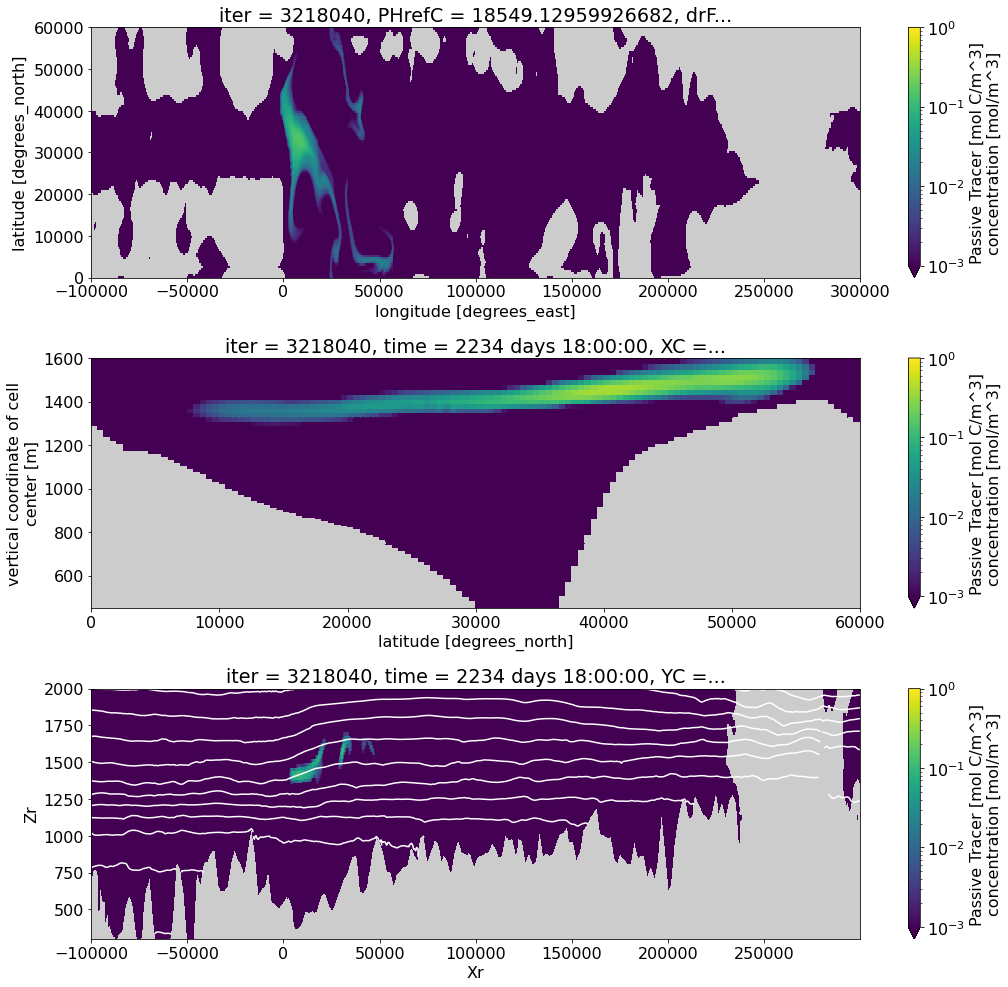

In [375]:
import matplotlib

plt.figure(figsize=(15,14))
plt.subplot(3,1,1, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=1390, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))

plt.subplot(3,1,2, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).sel(XC=5.e3, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
plt.tight_layout()
plt.ylim([450, 1600])

plt.subplot(3,1,3, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(0., 3., 0.1), colors='w', lw=0.75)

plt.tight_layout()
plt.ylim([300, 2000])

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100

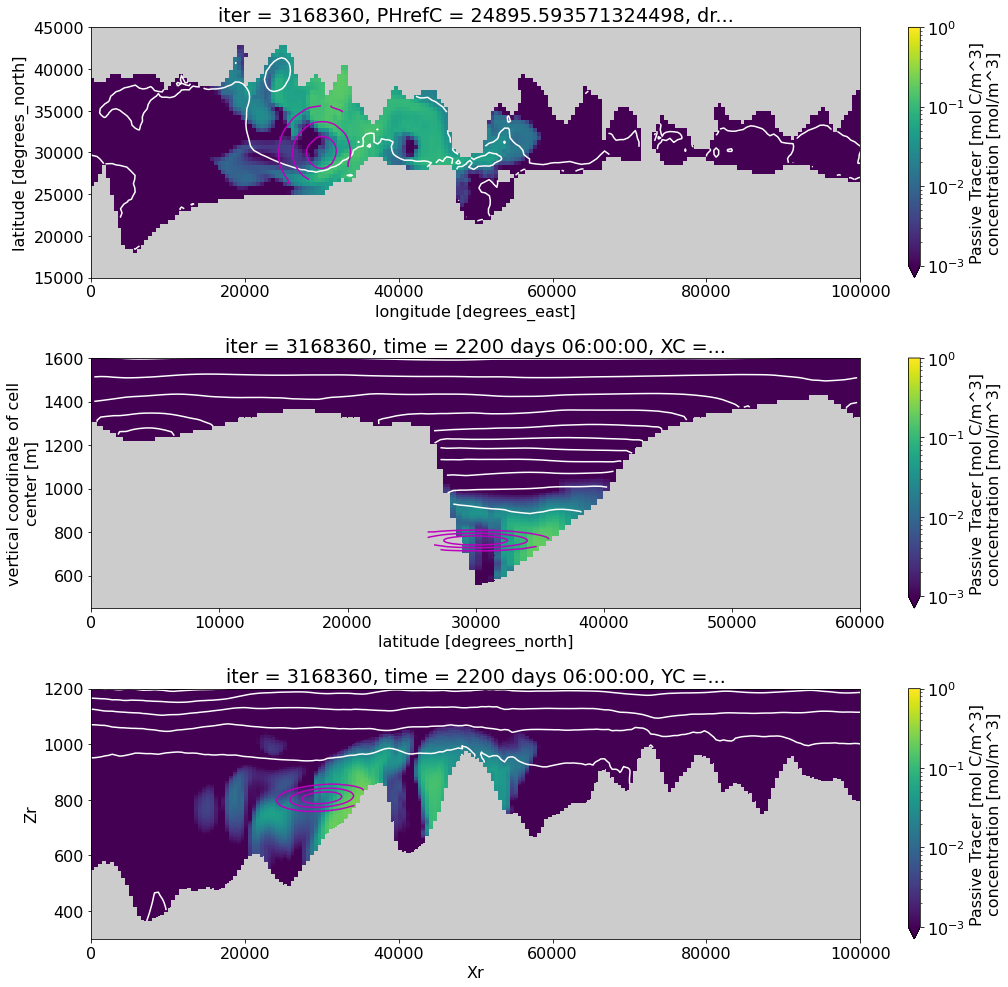

In [394]:
import matplotlib

plt.figure(figsize=(15,14))
plt.subplot(3,1,1, facecolor=nancol)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=850, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).sel(Z=850, method='nearest').plot.contour(levels=np.arange(-1., 1.5, 0.01), colors='w', lw=0.75)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=0).sel(Z=750, method='nearest').plot.contour(levels=np.arange(0.25, 1., 0.25), colors='m', lw=0.75)
plt.xlim([0,1.0e5])
plt.ylim([1.5e4,4.5e4])

plt.subplot(3,1,2, facecolor=nancol)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=-1).sel(XC=4.e4, method='nearest').plot(norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).sel(XC=4.e4, method='nearest').plot.contour(levels=np.arange(-1., 1.5, 0.05), colors='w', lw=0.75)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=0).sel(XC=3.e4, method='nearest').plot.contour(levels=np.arange(0.25, 1., 0.25), colors='m', lw=0.75)
plt.tight_layout()
plt.ylim([450, 1600])

plt.subplot(3,1,3, facecolor=nancol)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(-1., 1.5, 0.05), colors='w', lw=0.75)
ds['TRAC02'].where(ds['hFacC'] != 0.).isel(time=0, YC=60).plot.contour(x='Xr', y='Zr', levels=np.arange(0.25, 1., 0.25), colors='m', lw=0.75)
plt.ylim([300, 1200])
plt.xlim([0,1.0e5])

plt.tight_layout()


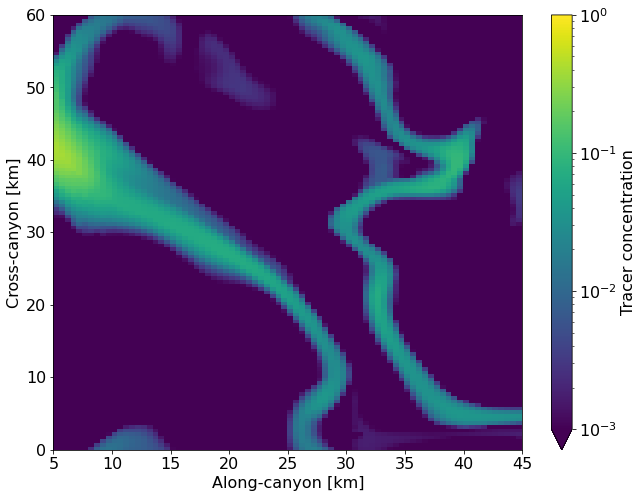

In [126]:
plt.figure(figsize=(10.5,8))
for i, t in enumerate(ds['time'].values):
    plt.clf()
    q = qplot.sel(time=t).plot(x='Xkm', y='Ykm',norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.0))
    plt.xlim([5, 45])
    plt.ylim([0, 60])
    plt.xlabel("Along-canyon [km]")
    plt.ylabel("Cross-canyon [km]")
    plt.title("")
    q.colorbar.set_label("Tracer concentration")
    plt.savefig(f"../../figures/movies/BBTRE_release/{str(i).zfill(3)}.png", dpi=100., bbox_inches="tight")